In [1]:
import sys
import os
sys.path.append('../')
import numpy as np
import scipy.signal as sps
from source.reader import read_raw
from source.interference_reject import InterferenceReject
import plotly  as py
import plotly.graph_objects as go

In [2]:
# Data import
file_name = "../../data_interference/shielded_room/inr_signal.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

In [3]:
# correct prescan data
select_signal_channels=[8,9,10,11]
interf_rej_1 = InterferenceReject(channels_signal=select_signal_channels,channels_noise=[12])
interf_rej_2 = InterferenceReject(channels_signal=select_signal_channels,channels_noise=[12,13])
interf_rej_3 = InterferenceReject(channels_signal=select_signal_channels,channels_noise=[12,13,14])
interf_rej_4 = InterferenceReject(channels_signal=select_signal_channels,channels_noise=[12,13,14,15])
data_raw = data['noise']
data_cor_1 = interf_rej_1.apply(data_signal=data_raw, data_noise=data_raw)
data_cor_2 = interf_rej_2.apply(data_signal=data_raw, data_noise=data_raw)
data_cor_3 = interf_rej_3.apply(data_signal=data_raw, data_noise=data_raw)
data_cor_4 = interf_rej_4.apply(data_signal=data_raw, data_noise=data_raw)

## Plot noise density (prescan)

In [9]:
from source.utils import compute_spectrogram
axis_pow, pow_raw = compute_spectrogram(data_raw[8:,:,:], acq_bandwidth)
axis_pow, pow_cor_1 = compute_spectrogram(data_cor_1, acq_bandwidth)
axis_pow, pow_cor_2 = compute_spectrogram(data_cor_2, acq_bandwidth)
axis_pow, pow_cor_3 = compute_spectrogram(data_cor_3, acq_bandwidth)
axis_pow, pow_cor_4 = compute_spectrogram(data_cor_4, acq_bandwidth)

# average noise in 10 kHz bandwidth
sel_passband = np.abs(axis_pow) < 5e3
sel_stopband = np.abs(axis_pow) > 15e3
avg_pow_raw = 10 * np.log10(np.mean(pow_raw[0, sel_passband]))
print("Average raw = {} dB".format(avg_pow_raw))
avg_pow_floor = 10 * np.log10(np.mean(pow_raw[0, sel_stopband]))
print("Average baseline = {} dB".format(avg_pow_floor))
avg_pow_1ch = 10 * np.log10(np.mean(pow_cor_1[0, sel_passband]))
print("Average 1 channel = {} dB".format(avg_pow_1ch))
avg_pow_2ch = 10 * np.log10(np.mean(pow_cor_2[0, sel_passband]))
print("Average 2 channel = {} dB".format(avg_pow_2ch))
avg_pow_3ch = 10 * np.log10(np.mean(pow_cor_3[0, sel_passband]))
print("Average 2 channel = {} dB".format(avg_pow_3ch))
avg_pow_4ch = 10 * np.log10(np.mean(pow_cor_4[0, sel_passband]))
print("Average 2 channel = {} dB".format(avg_pow_4ch))

# Interactive plot
fig = go.Figure()
fig.update_layout(plot_bgcolor="white")
line_style = {'color': 'orange', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log10(pow_raw[0, :]), line=line_style, name='Raw'))
line_style = {'color': 'gray', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log10(pow_cor_1[0, :]), line=line_style, name='1 reference coil'))
line_style = {'color': 'green', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log10(pow_cor_2[0, :]), line=line_style, name='2 reference coils'))
line_style = {'color': 'blue', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log10(pow_cor_3[0, :]), line=line_style, name='3 reference coils'))
line_style = {'color': 'black', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log10(pow_cor_4[0, :]), line=line_style, name='4 reference coils'))
fig.show()


Average raw = -5.890070205541399 dB
Average baseline = -35.88978372847285 dB
Average 1 channel = -13.070719849198413 dB
Average 2 channel = -14.950445875145643 dB
Average 2 channel = -16.31496392147063 dB
Average 2 channel = -17.116412921762496 dB


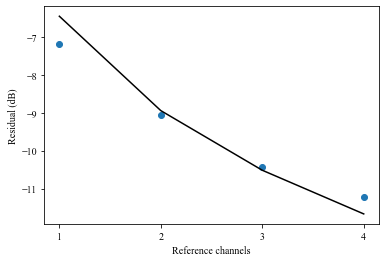

In [10]:
# Compare with theory sqrt(1/(1+k*INR**2))

# Model: noise coil INR is 4.5 dB, or INR = 1.7 (in amplitude)
k = np.arange(1, 5)
residual_model = 1 / np.sqrt(1 + k * 1.85 ** 2)
residual_model = 20 * np.log10(residual_model)

# Measured data: ration between raw and corrected
residual_measured = np.zeros(4)
residual_measured[0] = avg_pow_1ch - avg_pow_raw
residual_measured[1] = avg_pow_2ch - avg_pow_raw
residual_measured[2] = avg_pow_3ch - avg_pow_raw
residual_measured[3] = avg_pow_4ch - avg_pow_raw

import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams['font.size'] = 18
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))
ax.plot(k[:4], residual_measured, marker='o', linestyle='None')
ax.plot(k, residual_model, 'black')
ax.set_xticks(np.arange(1,5))
ax.set_xlabel("Reference channels")
ax.set_ylabel("Residual (dB)")
plt.show()

# Save figure
dir_data, file_data = os.path.split(file_name)
dir_fig = os.path.join(dir_data, "figures")
if not os.path.isdir(dir_fig):
    os.mkdir(dir_fig)
file_fig = os.path.splitext(file_data)[0] + ".png"
fig.savefig(os.path.join(dir_fig, file_fig))